# Collaborative Filtering
- collaborative filtering에서는 사용자와 아이템 간 상호작용 데이터를 바탕으로 어떤 사용자와 유사한 취향을 가진 사용자가 좋아하는 아이템을 추천하거나(user-based collaborative filtering) 어떤 아이템과 유사한 아이템을 추천합니다(item-based collaborative filtering).
- 사용자나 아이템의 세부정보와 다르게 상호작용 데이터는 시스템을 운영하면서 자연스럽게 축적되므로 데이터를 수집하고 정제하는 데 별도의 시간이 소요되지 않습니다.
- 여기서 핵심은 유사도를 어떻게 정의하는가입니다.

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from tensorflow.keras.utils import get_file
from itertools import combinations
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

In [3]:
movies = pd.read_csv("./Datasets/MovieLens/movies.csv", index_col=0)
genres = pd.read_csv("./Datasets/MovieLens/genres.csv", index_col=0)
gdd.download_file_from_google_drive(file_id="15vsm-VWAC3Y-7jr7ROL_xy0ufkIfqSke", dest_path="D:/ratings.csv")
ratings = pd.read_csv("D:/ratings.csv")
ratings = ratings.drop(["Unnamed: 0"], axis=1)

- 다음 5개 영화를 대상으로 알아보겠습니다.

In [4]:
target = {8957: "Saw", 2232: "Cube", 6323: "Identity", 8638: "Before Sunset", 215: "Before Sunrise"}

#각 영화의 세부정보를 가져옵니다.
df1 = movies[movies["id"].isin(target)]
df2 = genres[genres["movie_id"].isin(target)]

pd.merge(df1, df2, left_on="id", right_on="movie_id")

,id,title,release_year,movie_id,genre
0,215,Before Sunrise,1995,215,Drama
1,215,Before Sunrise,1995,215,Romance
2,2232,Cube,1997,2232,Horror
3,2232,Cube,1997,2232,Mystery
4,2232,Cube,1997,2232,Sci-Fi
5,2232,Cube,1997,2232,Thriller
6,6323,Identity,2003,6323,Crime
7,6323,Identity,2003,6323,Horror
8,6323,Identity,2003,6323,Mystery
9,6323,Identity,2003,6323,Thriller


In [5]:
#id:title의 dictionary를 만듭니다.
id2title = dict(zip(movies["id"], movies["title"]))
ratings["title"] = ratings["movie_id"].map(id2title)

#각 영화의 평점 데이터를 가져옵니다.
ratings_target = ratings[ratings["movie_id"].isin(target.keys())]

In [6]:
ratings_target

,user_id,movie_id,rating,rated_at,title
1099,11,2232,4.5,1230788590,Cube
3638,31,8957,0.5,1424736694,Saw
4977,50,215,5.0,1182347856,Before Sunrise
5058,50,8638,5.0,1182348573,Before Sunset
6156,56,215,3.0,1003025941,Before Sunrise
...,...,...,...,...,...
19997430,138472,8957,3.0,1267119268,Saw
19997639,138473,2232,4.5,1274234130,Cube
19998940,138483,215,4.0,833831946,Before Sunrise
19999482,138486,8957,5.0,1207076826,Saw


In [7]:
ratings_target_set = ratings_target.groupby("user_id")["title"].apply(set)

In [8]:
ratings_target_set

user_id
11                                 {Cube}
31                                  {Saw}
50        {Before Sunrise, Before Sunset}
56                       {Before Sunrise}
58                             {Identity}
                       ...               
138472                              {Saw}
138473                             {Cube}
138483                   {Before Sunrise}
138486                              {Saw}
138493                             {Cube}
Name: title, Length: 16922, dtype: object

- 5개의 영화를 모두 본 사용자만 뽑겠습니다.

In [9]:
all_seen = ratings_target_set[ratings_target_set.map(lambda x : len(x)==5)].index
ratings_all_seen = ratings_target[ratings_target["user_id"].isin(all_seen)]

In [10]:
ratings_all_seen

,user_id,movie_id,rating,rated_at,title
146330,982,215,3.5,1195746062,Before Sunrise
146993,982,2232,3.5,1141652908,Cube
147899,982,6323,3.0,1193323976,Identity
148143,982,8638,4.0,1195747667,Before Sunset
148181,982,8957,3.0,1141659791,Saw
...,...,...,...,...,...
19885812,137686,215,4.0,899415564,Before Sunrise
19886569,137686,2232,4.0,1087503954,Cube
19887442,137686,6323,3.5,1079896026,Identity
19887645,137686,8638,4.0,1151393086,Before Sunset


## User-Item Matrix
- 이 데이터를 바탕으로 user-item matrix를 만듭니다.

In [11]:
ui = pd.pivot_table(ratings_all_seen, index="user_id", columns="title", values="rating")

In [12]:
ui

title,Before Sunrise,Before Sunset,Cube,Identity,Saw
user_id,,,,,
982,3.5,4.0,3.5,3.0,3.0
1165,4.5,4.0,4.0,2.5,2.5
1288,4.0,3.5,3.5,3.0,4.0
2650,4.0,4.0,3.0,4.0,4.5
2669,4.0,4.0,3.5,4.0,3.5
...,...,...,...,...,...
133329,5.0,4.5,5.0,3.0,4.0
134290,4.0,4.5,4.0,3.0,3.5
135071,3.5,3.5,3.5,3.5,3.5


### 사용자와 아이템의 편향 제거하기
- 예를 들어 Saw에 똑같이 4점을 준 두 사용자가 동일한 정도로 그 영화를 좋아한다고 볼 수 없습니다.
- 왜냐하면 사용자 A는 웬만해서는 4점을 주지 않는 성향이고 사용자 B는 비교적 점수를 후하게 주는 성향일 수 있기 때문입니다.
- 또한 어떤 사용자가 Saw와 Before Sunset에 똑같이 4점을 주었다고 해도 Saw는 전반적으로 평가가 좋은 영화인 반면 Before Sunset은 이 사용자가 유일하게 높은 점수를 주었을 수도 있습니다.
- 이런 왜곡을 피하기 위해 사용자와 아이템의 편향을 각각 제거해주어야 합니다.

In [13]:
#사용자별 평균 평점
avg_rating_user = ui.mean(axis=1).sort_values()

In [14]:
avg_rating_user

user_id
116900    1.6
67346     1.9
22122     2.4
113668    2.4
15701     2.4
         ... 
87383     4.6
77247     4.6
101887    4.7
80285     4.8
74241     4.8
Length: 181, dtype: float64

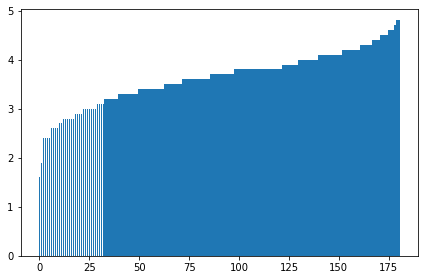

In [15]:
fig, ax = plt.subplots()

ax.bar(x=range(len(avg_rating_user)), height=avg_rating_user)

fig.tight_layout()

In [16]:
#아이템별 평균 평점
avg_rating_item = ui.mean(axis=0).sort_values()

In [17]:
avg_rating_item

title
Saw               3.298343
Identity          3.400552
Cube              3.577348
Before Sunset     3.881215
Before Sunrise    3.950276
dtype: float64

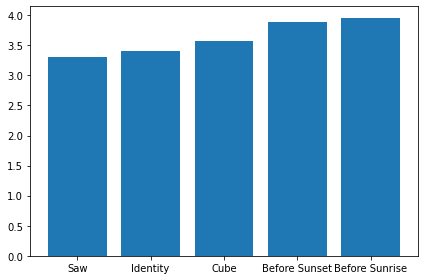

In [18]:
fig, ax = plt.subplots()

ax.bar(x=avg_rating_item.index, height=avg_rating_item)

fig.tight_layout()

- 사용자 편향과 아이템 편향을 반영하여 user-item matrix를 조정합니다.

In [19]:
avg_rating = ui.mean().mean()

#사용자 편향을 계산합니다.
user_bias = ui.mean(axis=1) - avg_rating
#아이템 편향을 계산합니다.
item_bias = ui.mean(axis=0) - avg_rating

adj_ui = ui.sub(user_bias, axis=0).sub(item_bias, axis=1)

In [20]:
adj_ui.sample(5)

title,Before Sunrise,Before Sunset,Cube,Identity,Saw
user_id,,,,,
2650,3.392818,3.461878,2.765746,3.942541,4.544751
80501,2.492818,2.061878,4.365746,4.542541,4.644751
65304,3.592818,4.661878,3.965746,3.142541,2.744751
13431,3.792818,3.861878,3.165746,4.342541,2.944751
130767,4.792818,4.361878,3.665746,2.842541,2.444751


# Similarity 구하기
- 거리 기반 유사도 : 유클리드 거리 유사도 등
- 방향 기반 유사도 : 코사인 유사도 등

## User-Based Collaborative Filtering

In [21]:
#adj_ui에서 5개의 샘플만 랜덤으로 뽑겠습니다.
sample5 = adj_ui.sample(5)

In [22]:
sample5

title,Before Sunrise,Before Sunset,Cube,Identity,Saw
user_id,,,,,
120572,4.092818,4.161878,3.465746,3.642541,2.744751
40285,2.692818,2.261878,4.065746,4.242541,4.844751
110048,3.292818,4.361878,1.665746,4.842541,3.944751
71970,3.092818,3.661878,4.465746,3.142541,3.744751
133329,3.992818,3.561878,4.365746,2.542541,3.644751


In [23]:
#유클리드 거리 기반 유사도를 계산하는 함수를 만듭니다.
def euc_sim(x, y):
    return 1/(1 + np.sqrt(np.sum((x - y)**2)))

#코사인 유사도를 계산하는 함수를 만듭니다.
def cos_sim(x, y):
    return np.sum(x*y)/(np.linalg.norm(x)*np.linalg.norm(x))

In [24]:
for user1, user2 in combinations(sample5.index, 2):
    sim1 = euc_sim(sample5.loc[user1], sample5.loc[user2])
    sim2 = cos_sim(sample5.loc[user1], sample5.loc[user2])
    print(f"{user1:>6d} | {user2:>6d} | euc_sim : {sim1:>4.3f} | cos_sim : {sim2:>4.3f}")

120572 |  40285 | euc_sim : 0.234 | cos_sim : 0.946
120572 | 110048 | euc_sim : 0.277 | cos_sim : 0.985
120572 |  71970 | euc_sim : 0.348 | cos_sim : 0.973
120572 | 133329 | euc_sim : 0.359 | cos_sim : 0.980
 40285 | 110048 | euc_sim : 0.226 | cos_sim : 0.926
 40285 |  71970 | euc_sim : 0.316 | cos_sim : 0.941
 40285 | 133329 | euc_sim : 0.264 | cos_sim : 0.924
110048 |  71970 | euc_sim : 0.229 | cos_sim : 0.887
110048 | 133329 | euc_sim : 0.212 | cos_sim : 0.874
 71970 | 133329 | euc_sim : 0.477 | cos_sim : 0.996


## Item-Based Collaborative Filtering

In [108]:
adj_ui.T

user_id,982,1165,1288,2650,2669,3676,3907,5725,6099,6373,...,131180,131736,132509,132603,133133,133329,134290,135071,137277,137686
title,,,,,,,,,,,,,,,,,,,,,
Before Sunrise,3.392818,4.292818,3.692818,3.392818,3.492818,3.292818,3.892818,3.392818,3.192818,2.992818,...,4.092818,2.792818,3.492818,3.692818,3.392818,3.992818,3.492818,3.292818,3.192818,3.492818
Before Sunset,3.961878,3.861878,3.261878,3.461878,3.561878,3.361878,4.461878,3.961878,4.261878,3.061878,...,3.661878,2.861878,4.061878,3.261878,3.461878,3.561878,4.061878,3.361878,3.761878,3.561878
Cube,3.765746,4.165746,3.565746,2.765746,3.365746,3.165746,3.765746,3.765746,3.065746,3.365746,...,3.465746,4.165746,3.865746,3.565746,3.765746,4.365746,3.865746,3.665746,3.565746,3.865746
Identity,3.442541,2.842541,3.242541,3.942541,4.042541,4.342541,3.442541,2.942541,3.742541,4.042541,...,3.142541,3.842541,4.042541,3.742541,3.442541,2.542541,3.042541,3.842541,3.742541,3.542541
Saw,3.544751,2.944751,4.344751,4.544751,3.644751,3.944751,2.544751,4.044751,3.844751,4.644751,...,3.744751,4.444751,2.644751,3.844751,4.044751,3.644751,3.644751,3.944751,3.844751,3.644751


In [117]:
for item1, item2 in combinations(adj_ui.T.index, 2):
    sim1 = euc_sim(adj_ui.T.loc[item1], adj_ui.T.loc[item2])
    sim2 = cos_sim(adj_ui.T.loc[item1], adj_ui.T.loc[item2])
    print(f"{item1:>14s} | {item2:>14s} | euc_sim : {sim1:>4.3f} | cos_sim : {sim2:>4.3f}")

Before Sunrise |  Before Sunset | euc_sim : 0.112 | cos_sim : 0.987
Before Sunrise |           Cube | euc_sim : 0.063 | cos_sim : 0.954
Before Sunrise |       Identity | euc_sim : 0.064 | cos_sim : 0.955
Before Sunrise |            Saw | euc_sim : 0.056 | cos_sim : 0.947
 Before Sunset |           Cube | euc_sim : 0.063 | cos_sim : 0.954
 Before Sunset |       Identity | euc_sim : 0.064 | cos_sim : 0.955
 Before Sunset |            Saw | euc_sim : 0.056 | cos_sim : 0.947
          Cube |       Identity | euc_sim : 0.072 | cos_sim : 0.965
          Cube |            Saw | euc_sim : 0.071 | cos_sim : 0.969
      Identity |            Saw | euc_sim : 0.072 | cos_sim : 0.972
